# PyCPT 2 S2S prototype

This is an example of a PyCPT Version 2 subseasonal-to-seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to 

1. download data from the IRI Data Library (through the CPT-DL python library) 
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE) 
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast. 

PyCPT Version 2 was primarily designed and implemented by Kyle Hall.

## Function documentation
To get help on a function, e.g. `pycpt.setup`, run the following command in a new cell:
```
pycpt.setup?
```
To see the function's source code, use two question marks instead of one.

#### Imports - This cell imports PyCPTv2 libraries 

In [1]:
import pycpt
import packaging
min_version = '2.5.0'
assert packaging.version.parse(pycpt.__version__) >= packaging.version.parse(min_version), f'This notebook requires version {min_version} or higher of the pycpt library, but you have version {pycpt.__version__}. Please close the notebook, update your environment, and load the notebook again. See https://iri-pycpt.github.io/installation/'

import cptdl as dl 
from cptextras import get_colors_bars
import datetime as dt
import numpy as np
from pathlib import Path
from pycpt import subseasonal
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cartopyFeature
from cartopy.io.shapereader import Reader
regions = r'/home/tamirat/Desktop/eth_adm_csa_bofedb_2021_shp/eth_admbnda_adm2_csa_bofedb_2021.shp'#adding country shapefiles
regionShape = cartopyFeature.ShapelyFeature(Reader(regions).geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')

#### Define case directory
The directory where inputs, outputs, and figures generated by this notebook will be stored.

In [3]:
case_dir = Path.home() / "Desktop/PyCPT" / "SAsia_S2S_startJun"

#### Parameters - This cell defines the parameters of your CPT analysis

In [4]:
MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"

# Use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors.
# Make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands.
predictor_names = ["GEFSv12.PRCP"]
predictand_name = 'CHIRPS.PRCP'

# To download predictand observations from the Data Library, set
#
#   local_predictand_file = None
#
# To read predictand data from a local file instead,
# set local_predictand_file to the full pathname of the file. e.g.
#
#   local_predictand_file = "/home/aaron/src/pycpt_notebooks/obs_PRCP_Oct-Dec.tsv"
#
# The file should be formatted according to the following guidelines:
# https://cpthelp.iri.columbia.edu/CPT_use_input_gridded.html7
local_predictand_file = None


download_args = { 
    # 'fdate':
    #   The initialization date of the model forecasts / hindcasts.
    #   This field is defined by a python datetime.datetime object,
    #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
    #   The year field is only used for forecasts, otherwise ignored.
    #   The day field is only used in subseasonal forecasts, otherwise ignored.
    #   The month field is an integer representing a month - ie, May=5.
    'fdate':  dt.datetime(2023, 6, 1),
    
    # 'leads':
    #   A list of target periods, each of which is represented as (name, start, end), where
    #   start and end are numbers of days after the forecast date. For example, if
    #   fdate is 15 Jun then ('Week1', 1, 7) represents a target period of 16-22 Jun.
    'leads': [
        ('Week 1', 1, 7),
        ('Week 2', 8, 14),
    ],

    # 'training_season':
    #   The training set will comprise hindcasts issued within this range of months.
    #   E.g. 'May-Jul'
    'training_season': 'May-Jul',

    # 'predictor_extent':
    #   The geographic bounding box of the climate model data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictor_extent': {
        'east':  58,
        'west': 23, 
        'north': 25,
        'south': -7, 
    }, 

    # 'predictand_extent':
    #   The geographic bounding box of the observation data you want to download.
    #   This field is defined by a python dictionary with the keys "north", "south",
    #   "east", and "west", each of which maps to a python integer representing the 
    #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
    #   "south" the southernmost boundary.
    #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
    'predictand_extent': {
        'east':  48,
        'west': 33,  
        'north': 15,  
        'south': 3, 
    },

    # 'filetype':
    #   The filetype to be downloaded. for now, it saves a lot of headache just to set this equal
    #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata.
    'filetype': 'cptv10.tsv'
}

cpt_args = { 
    'transform_predictand': None,  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, 'Anomaly'
    'cca_modes': (1,3), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,8), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components 
    'validation': 'retroactive', # the type of validation to use; only 'retroactive' is supported for now
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
    'retroactive_initial_training_period': 45, # percent of samples to be used as initial training period for retroactive validation
    'retroactive_step': 10, # percent of samples to increment retroactive training period by each time
    
    # Options for use while debugging:
    'cpt_kwargs': {
        # 'outputdir': 'temp-outputs',  # uncomment to retain CPT output files after it finishes
        # 'interactive': True, # uncomment to see detailed output from CPT
    },
}


force_download = False

In [5]:
domain_dir = pycpt.setup(case_dir, download_args["predictor_extent"])

Input data will be saved in /home/tamirat/Desktop/PyCPT/SAsia_S2S_startJun/23W-58E_to_-7S-25N/data
Figures will be saved in /home/tamirat/Desktop/PyCPT/SAsia_S2S_startJun/23W-58E_to_-7S-25N/figures
Output will be saved in /home/tamirat/Desktop/PyCPT/SAsia_S2S_startJun/23W-58E_to_-7S-25N/output


#### Visualize predictor and predictand domains

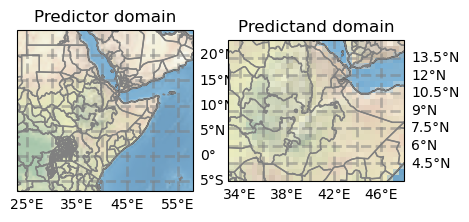

In [6]:
pycpt.plot_domains(download_args['predictor_extent'], download_args['predictand_extent'])

#### Download Observations, Hindcasts, and Forecasts from IRI Data Library

In [7]:
hindcast_data, Y, forecast_data = subseasonal.download_data(predictor_names, predictand_name, download_args, domain_dir, force_download)

#### Perform CPT Analysis

In [8]:
hcsts, fcsts, skill, pxs, pys = subseasonal.evaluate_models(hindcast_data, forecast_data, Y, MOS, cpt_args, domain_dir)

#### Plot skill of individual models

Deterministic skill metrics:
- pearson
- spearman
- two_alternative_forced_choice
- roc_area_below_normal (Area under ROC curve for Below Normal category)
- roc_area_above_normal (Area under ROC curve for Above Normal category)

Probabilistic skill metrics:
- generalized_roc
- rank_probability_skill_score

In [9]:
skill_metrics = [
    "pearson",
    "spearman",
    "two_alternative_forced_choice",
    "roc_area_below_normal",
    "roc_area_above_normal",
    "generalized_roc",
    "rank_probability_skill_score"
]

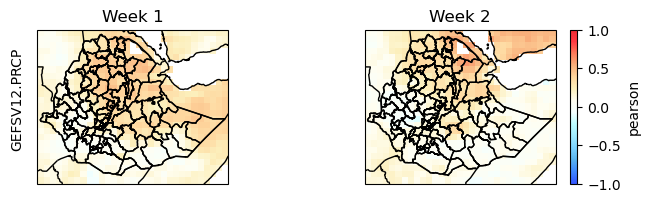

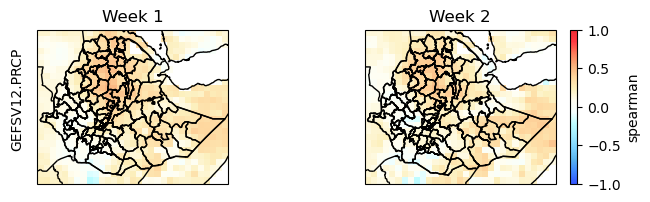

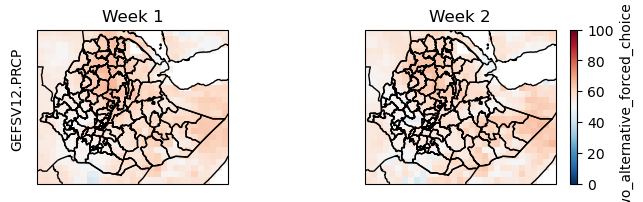

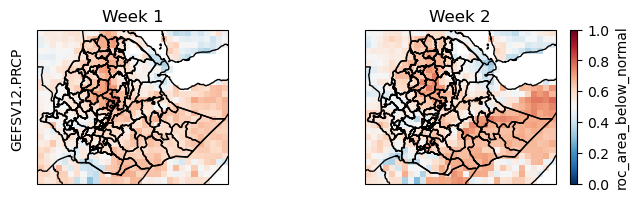

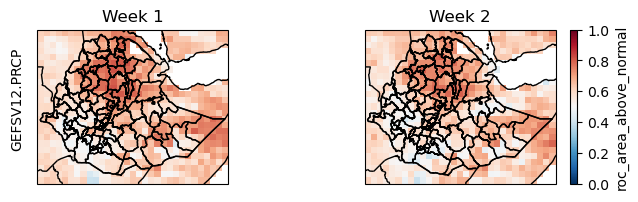

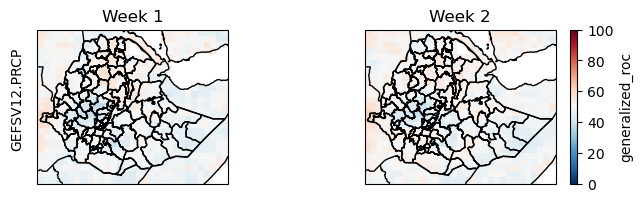

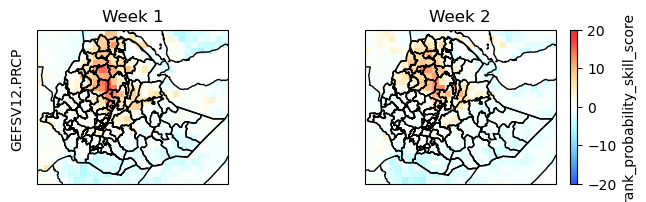

In [10]:
subseasonal.plot_skill(skill, MOS, domain_dir, skill_metrics, regionShape)

#### Plot EOF Modes

GEFSV12.PRCP Week 1: EOF 1


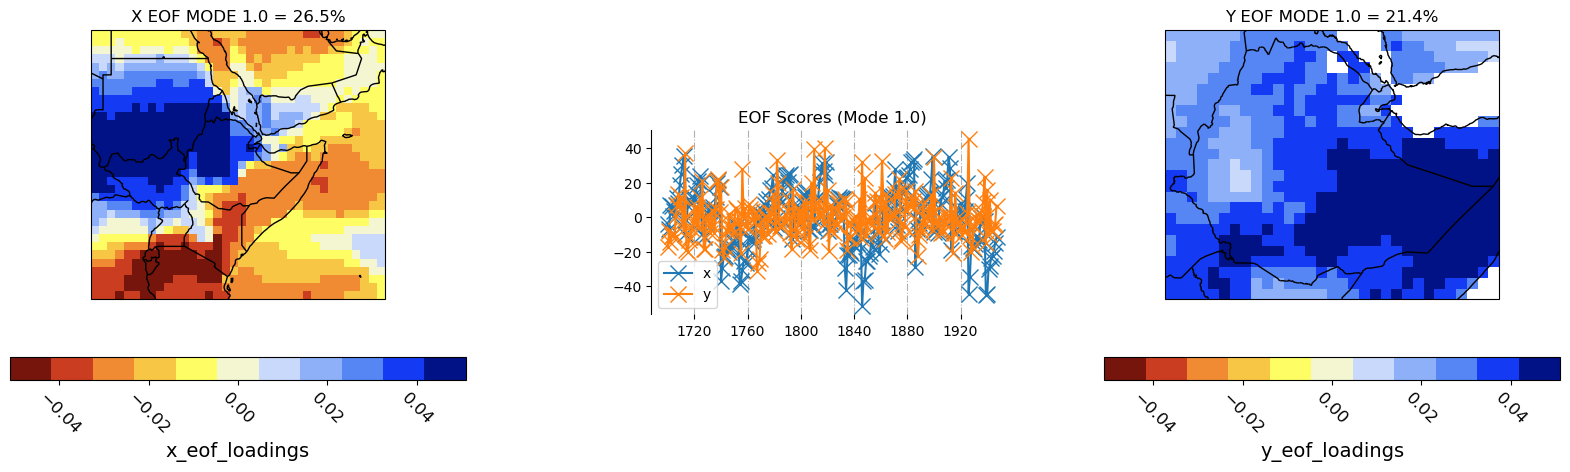

GEFSV12.PRCP Week 1: EOF 2


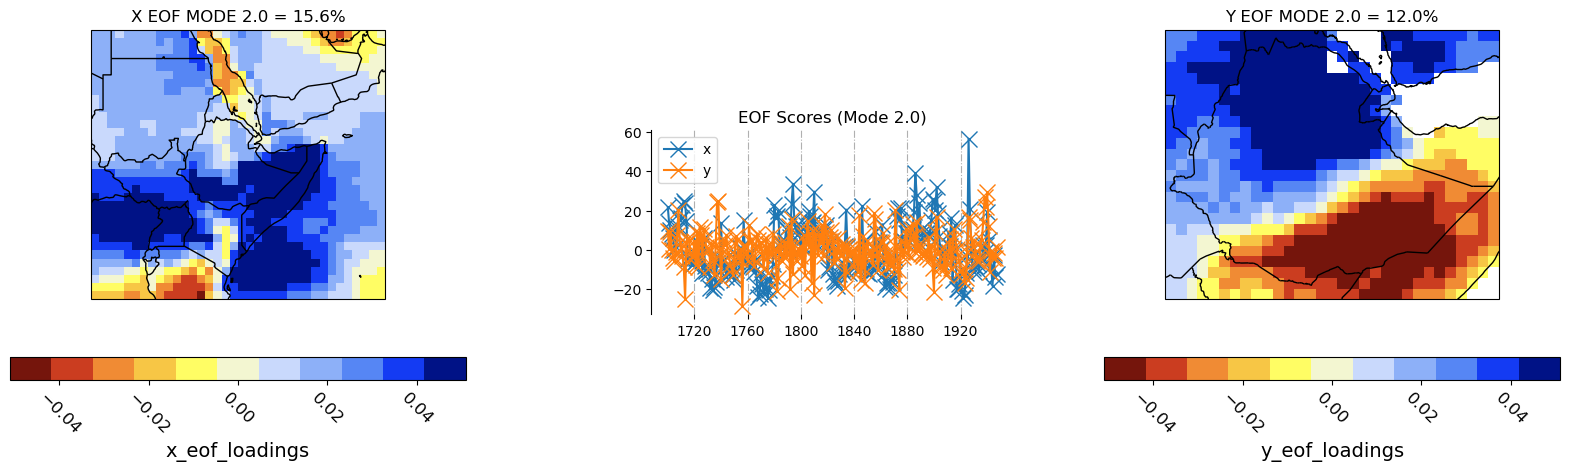

GEFSV12.PRCP Week 1: EOF 3


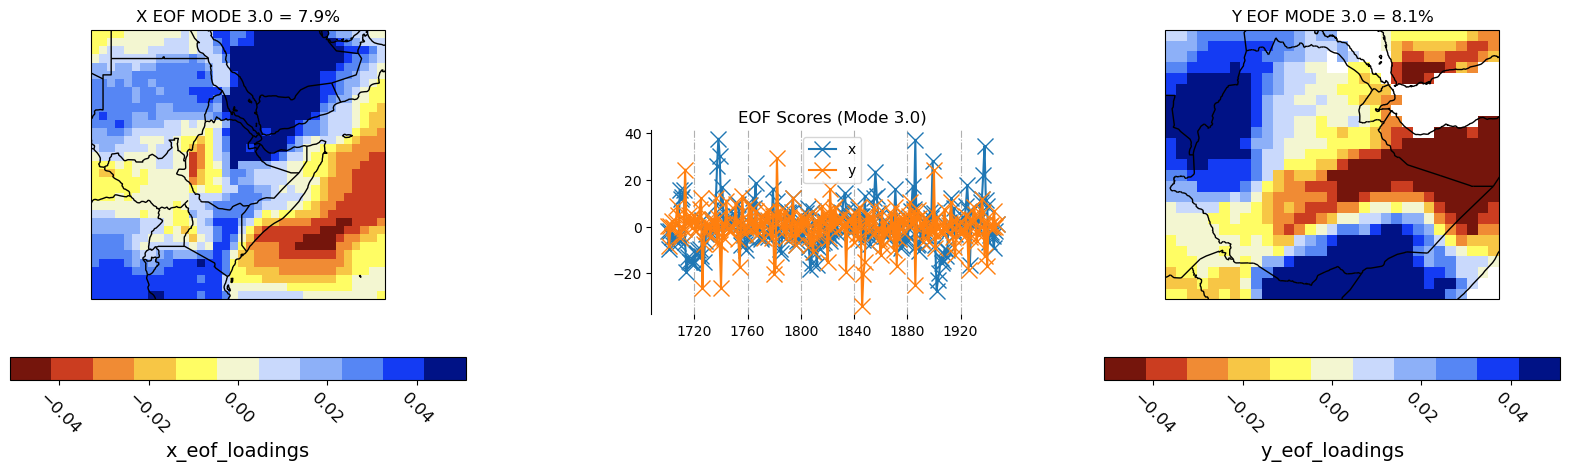

GEFSV12.PRCP Week 1: EOF 4


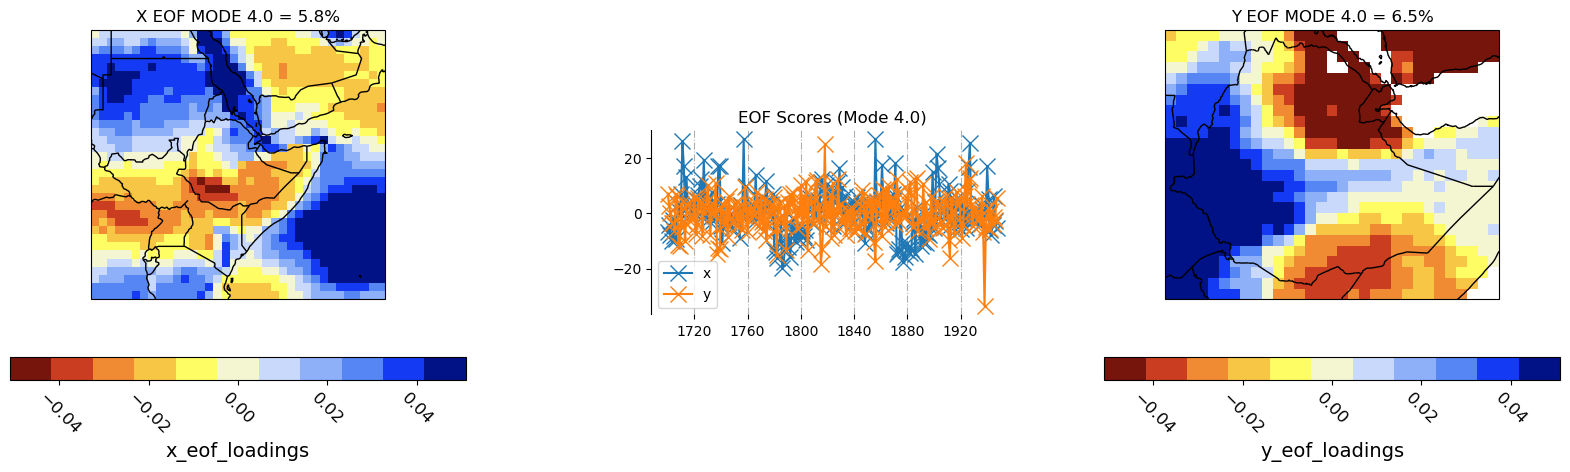

GEFSV12.PRCP Week 1: EOF 5


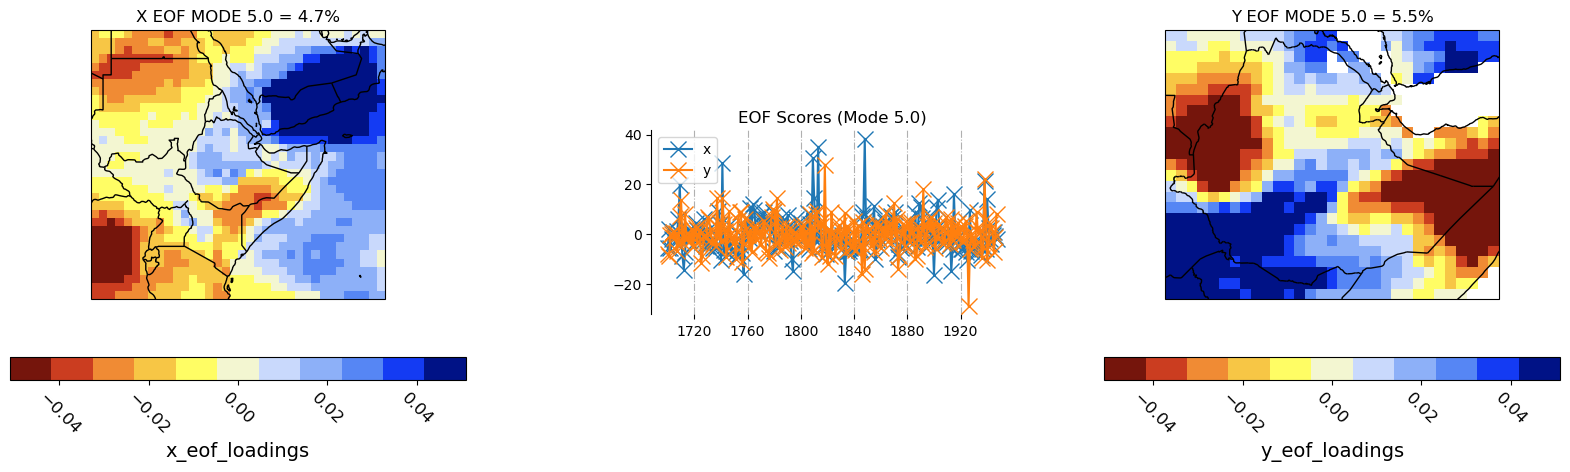

GEFSV12.PRCP Week 1: EOF 6


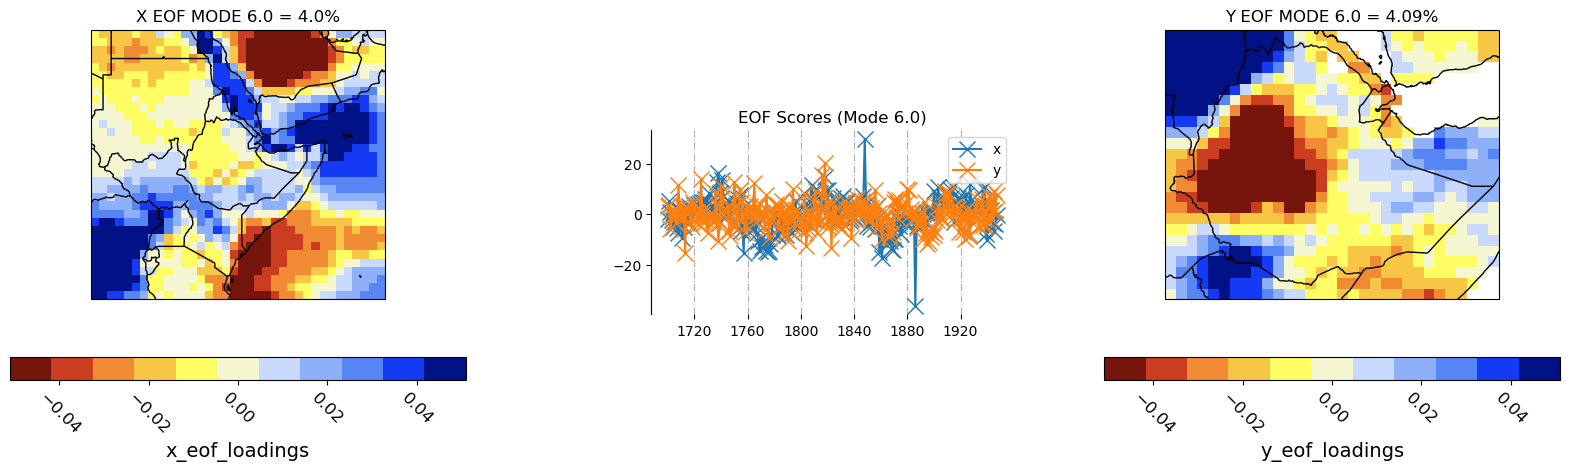

GEFSV12.PRCP Week 2: EOF 1


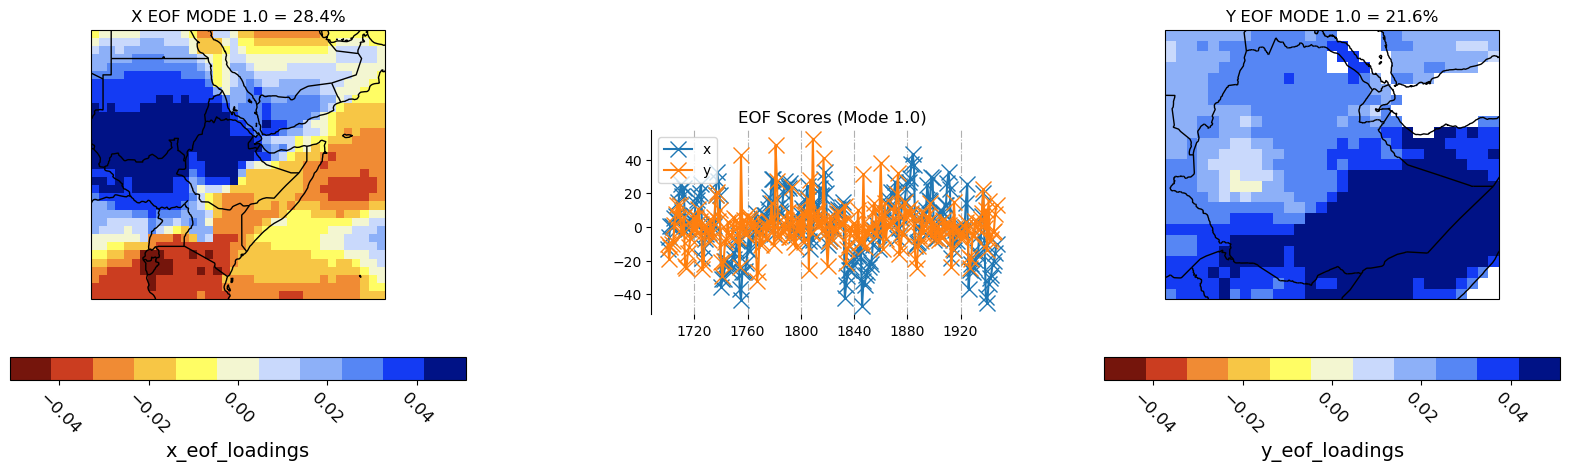

GEFSV12.PRCP Week 2: EOF 2


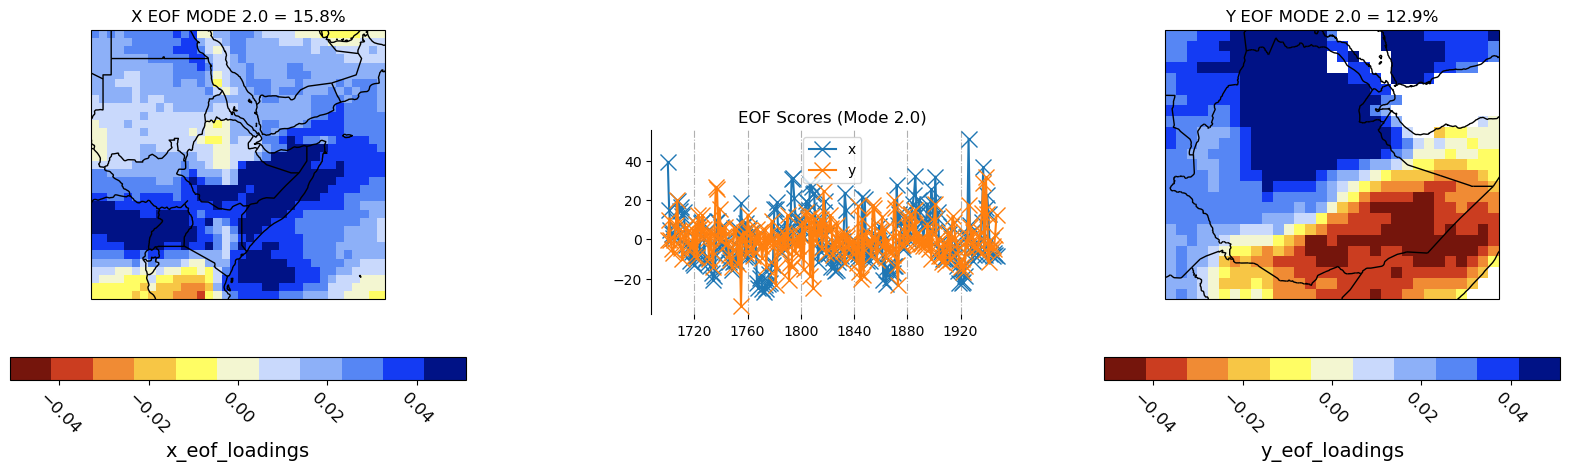

GEFSV12.PRCP Week 2: EOF 3


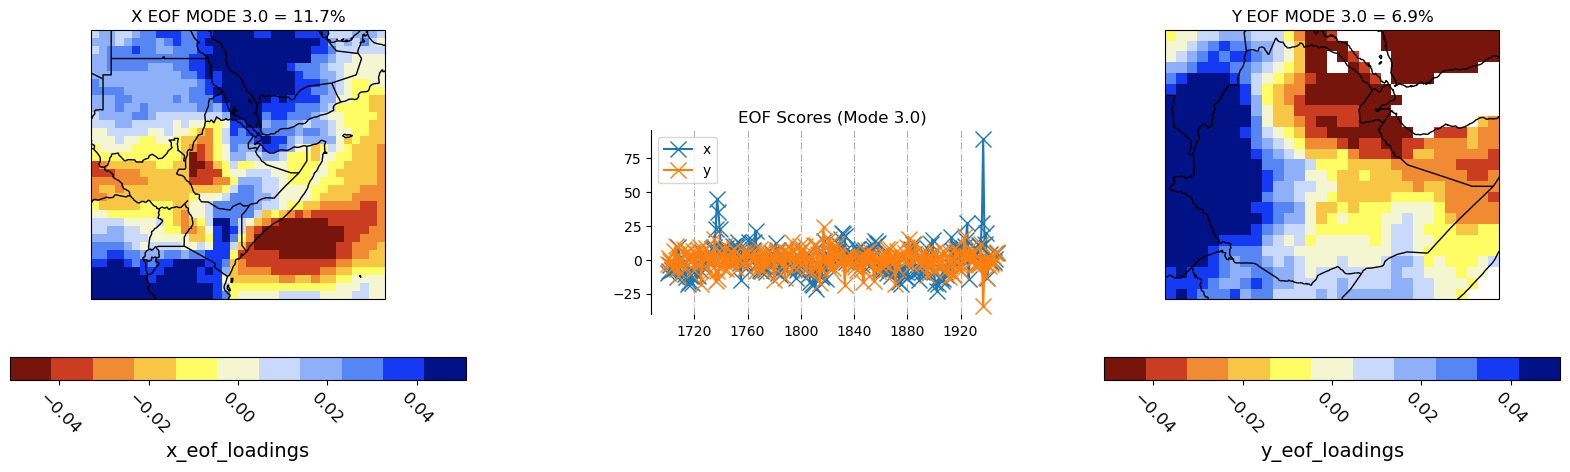

GEFSV12.PRCP Week 2: EOF 4


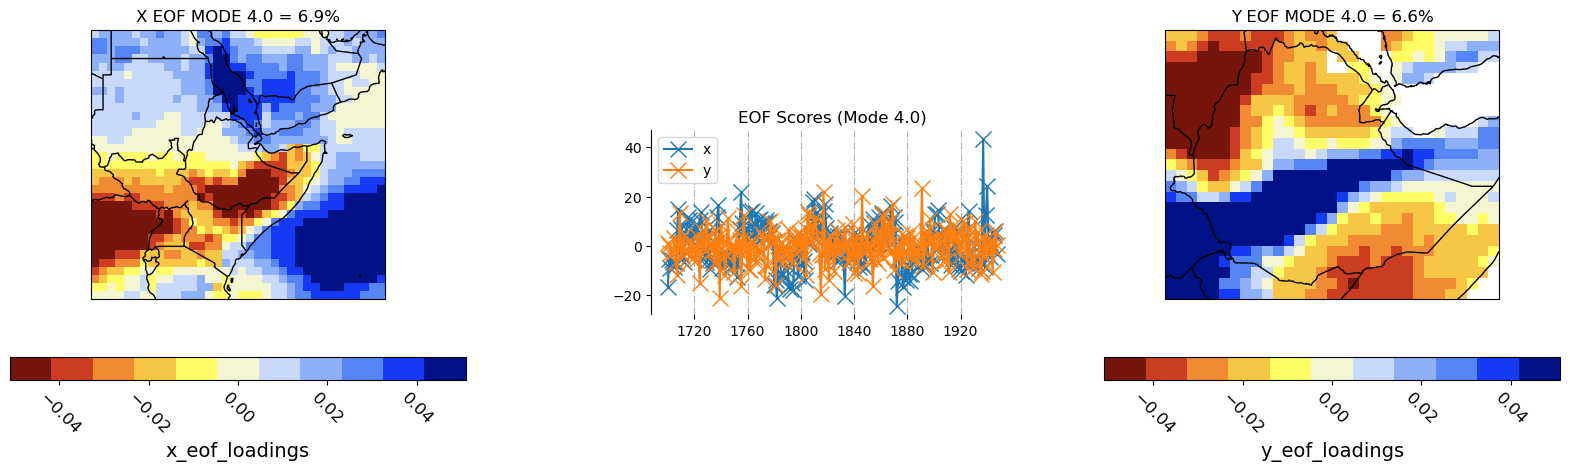

GEFSV12.PRCP Week 2: EOF 5


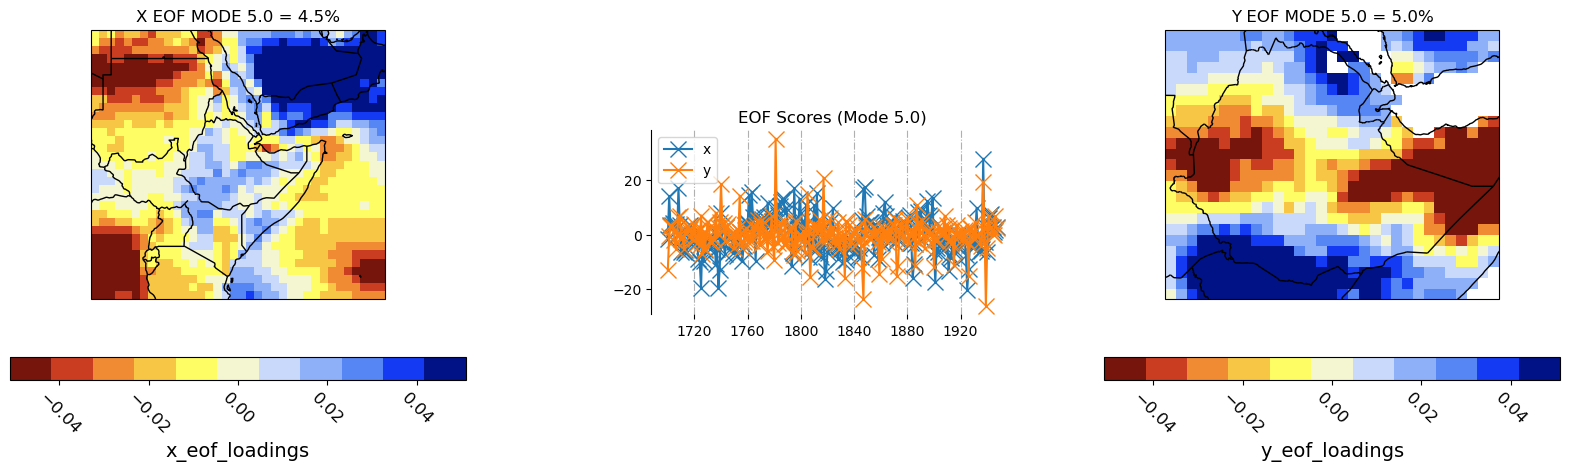

GEFSV12.PRCP Week 2: EOF 6


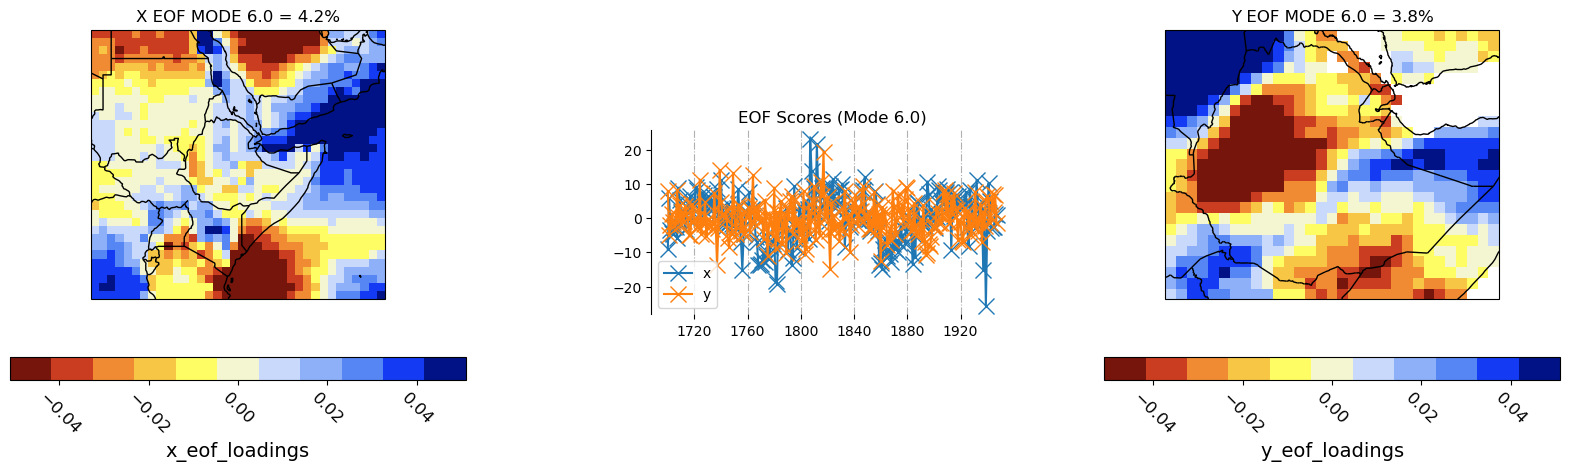

In [11]:
subseasonal.plot_eof_modes(pxs, pys, MOS, domain_dir)

#### Plot CCA Modes

GEFSV12.PRCP Week 1: CCA MODE 1 - Canonical Correlation = 0.65


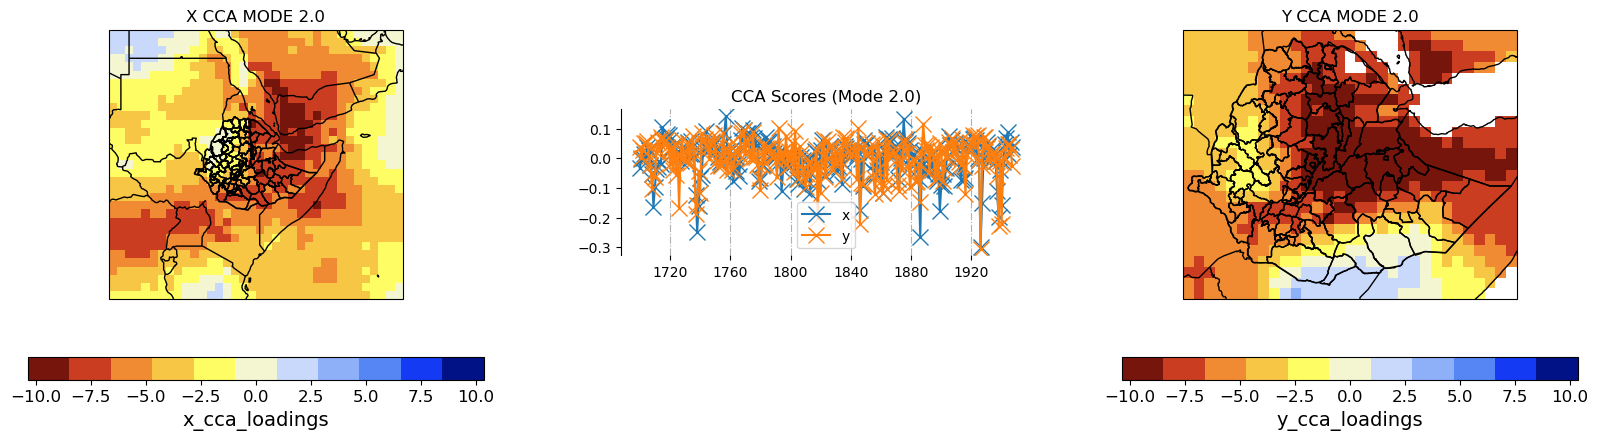

GEFSV12.PRCP Week 1: CCA MODE 2 - Canonical Correlation = 0.4


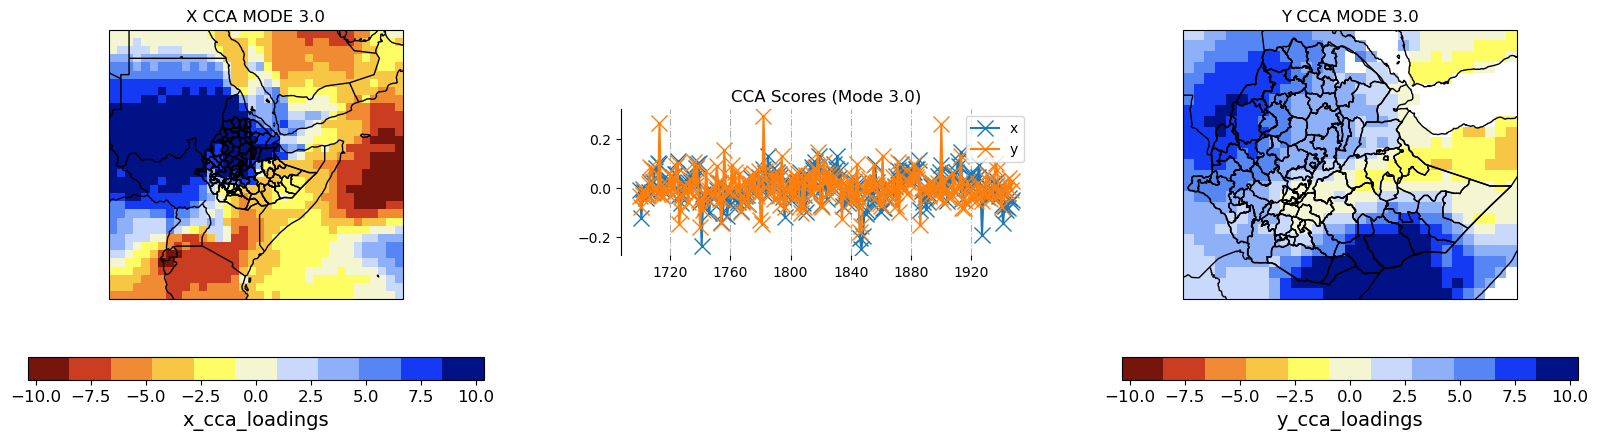

GEFSV12.PRCP Week 1: CCA MODE 3 - Canonical Correlation = nan


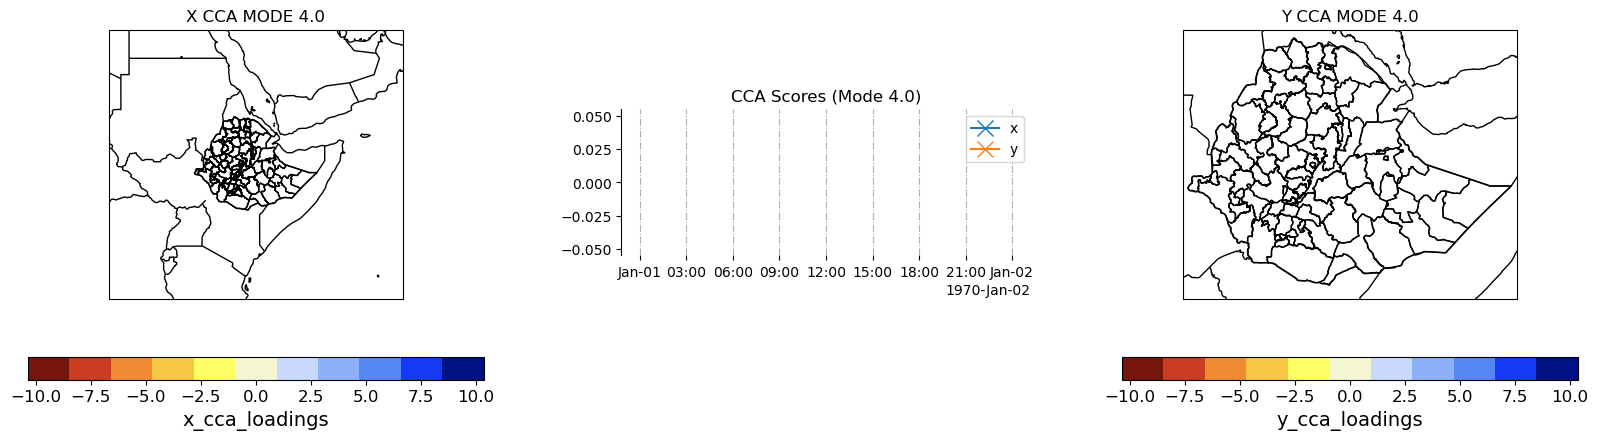

GEFSV12.PRCP Week 1: CCA MODE 4 - Canonical Correlation = nan


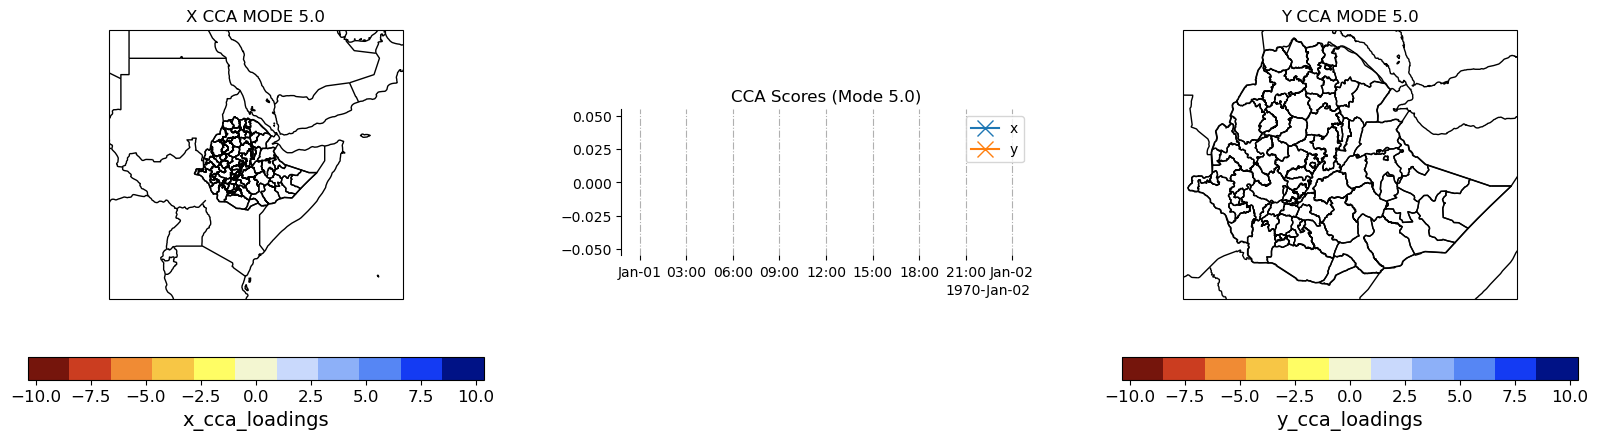

GEFSV12.PRCP Week 2: CCA MODE 1 - Canonical Correlation = 0.54


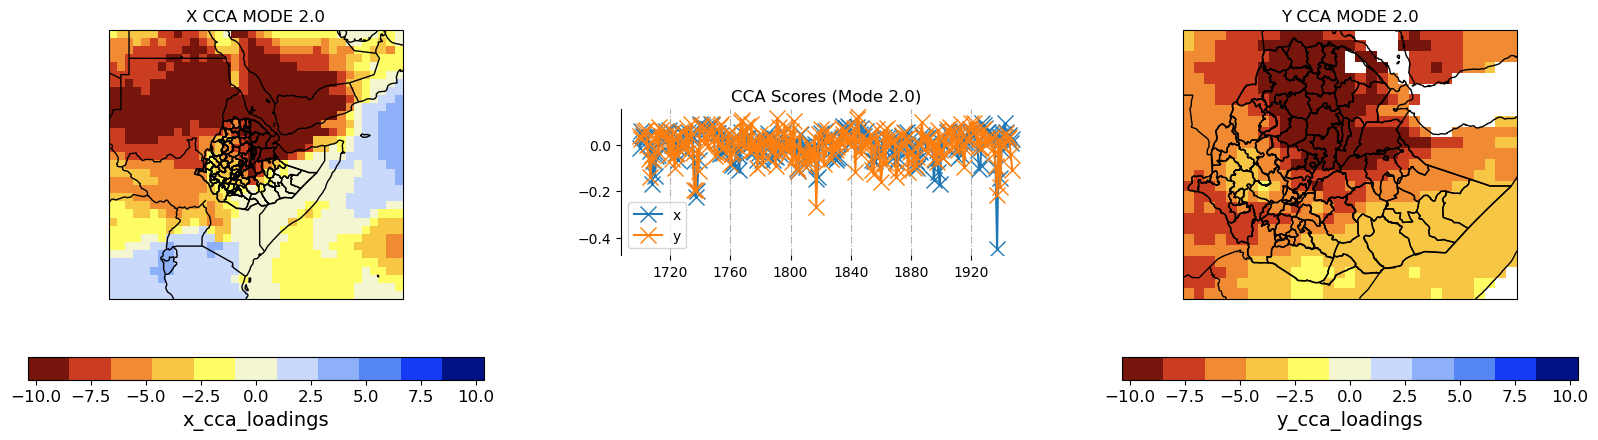

GEFSV12.PRCP Week 2: CCA MODE 2 - Canonical Correlation = 0.28


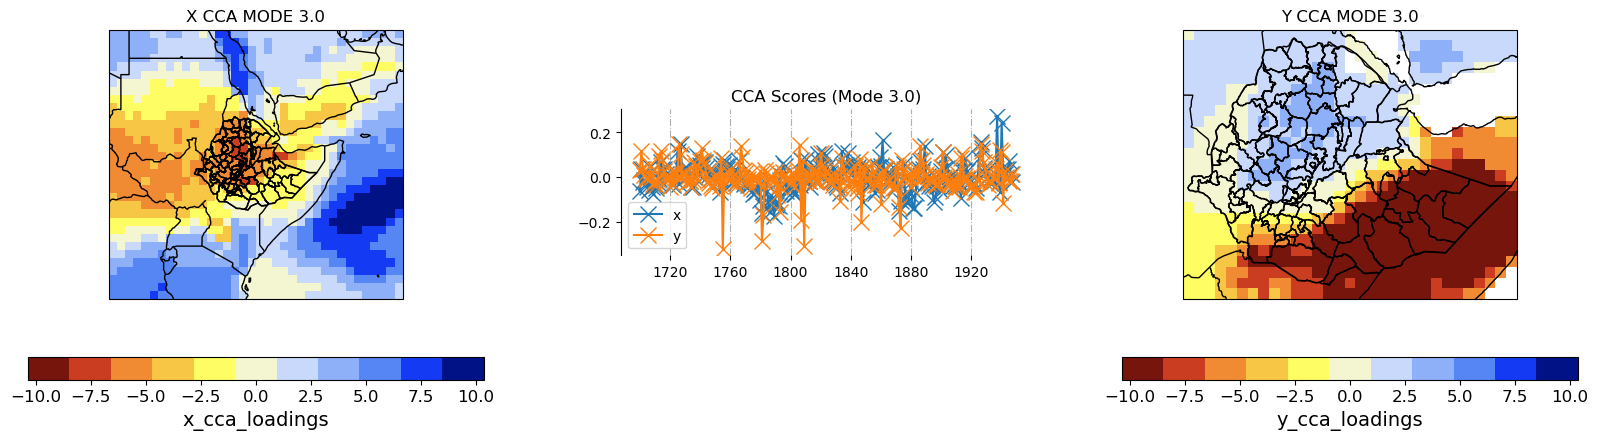

GEFSV12.PRCP Week 2: CCA MODE 3 - Canonical Correlation = nan


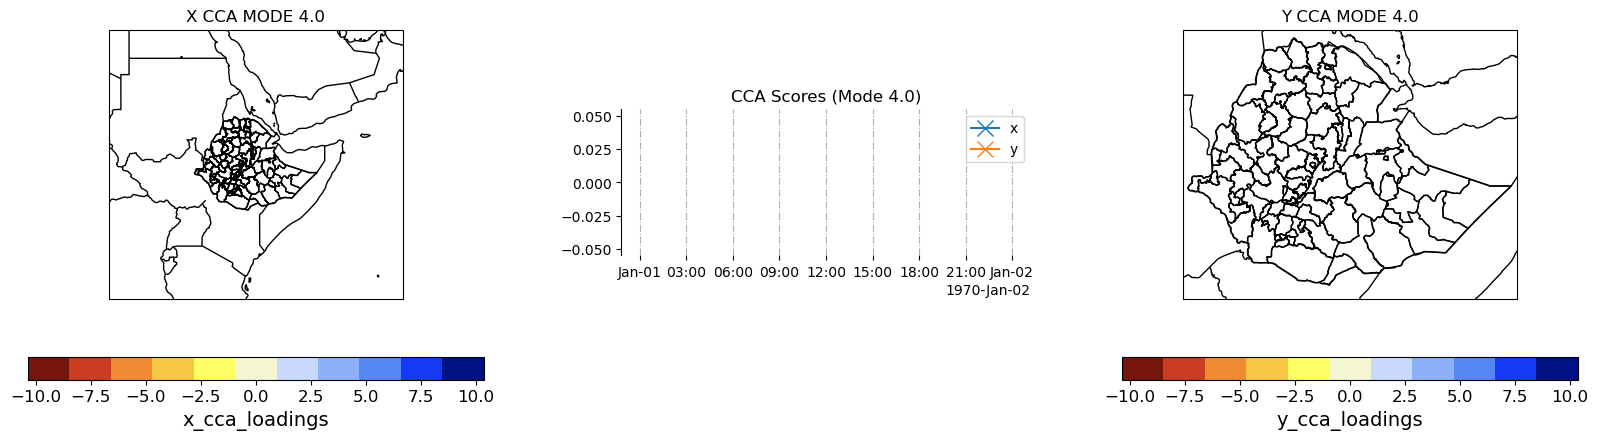

GEFSV12.PRCP Week 2: CCA MODE 4 - Canonical Correlation = nan


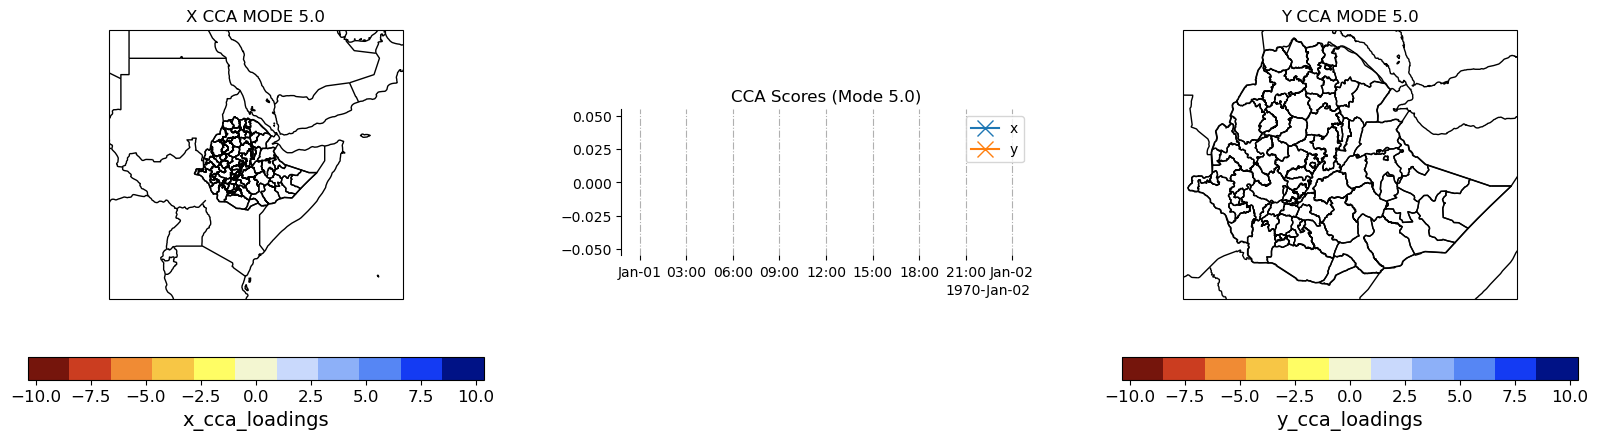

In [12]:
subseasonal.plot_cca_modes(pxs, pys, MOS, domain_dir, regionShape)

#### Plot Forecasts

Colormap to use for deterministic forecast. To see available colormaps, run `get_colors_bars()`.

In [13]:
det_fcst_cmap = 'DL_PRCP_ANOMALY'
det_fcst_vmin = -15
det_fcst_vmax = 15

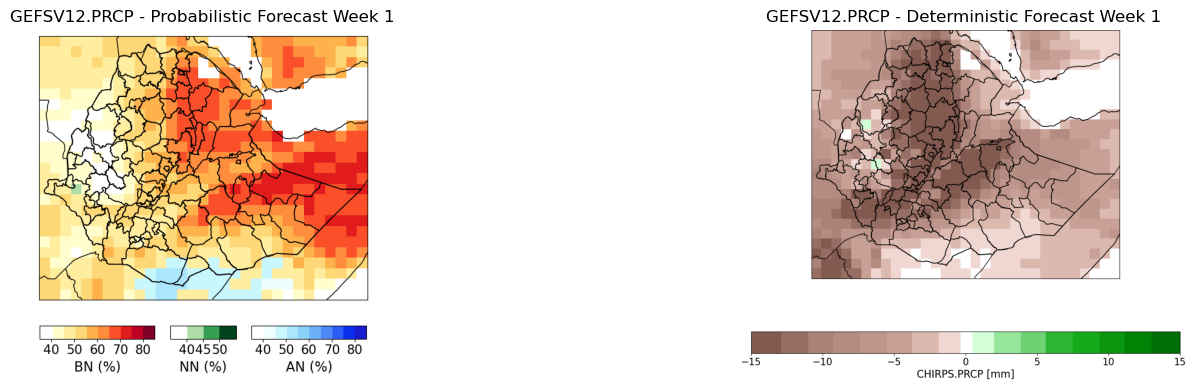

<Figure size 700x900 with 0 Axes>

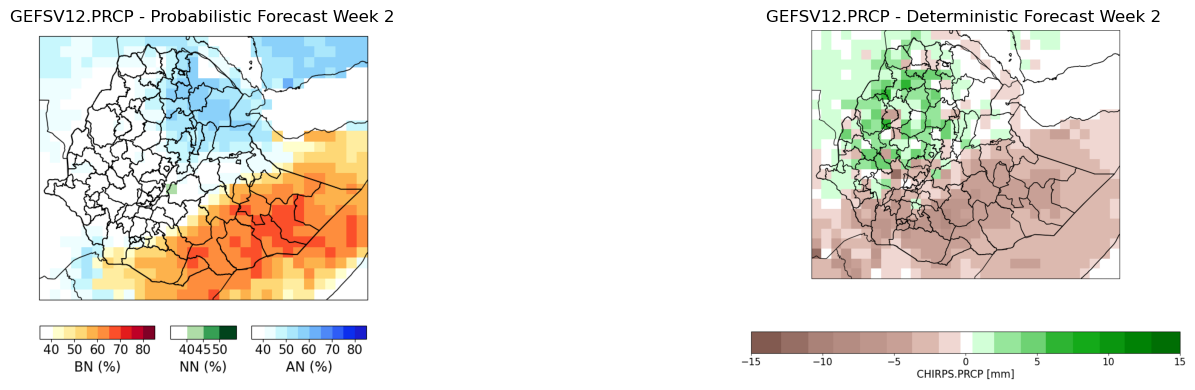

<Figure size 700x900 with 0 Axes>

In [14]:
subseasonal.plot_forecasts(fcsts, predictand_name, MOS, cpt_args, domain_dir, color_bar=det_fcst_cmap, vmin=det_fcst_vmin, vmax=det_fcst_vmax, adminLevel=regionShape)

In [15]:
# Placeholder for future addition of multi-model ensemble
#det_fcst, pr_fcst, pev_fcst, nextgen_skill = subseasonal.construct_mme(hcsts, Y, fcsts, ensemble, cpt_args, domain_dir)
f0 = fcsts.isel(model=0)
det_fcst = f0['deterministic']
pev_fcst = f0['prediction_error_variance']

#### Construct Flexible Forecast (full PDF)

If `isPercentile` is `True`, the threshold is a percentile (e.g., 0.5)
else in the unit of the predictand (e.g., mm, degC, ...)

In [16]:
threshold = 0.5
isPercentile = True

In [17]:
exceedance_prob, fcst_scale, climo_scale, fcst_mu, climo_mu, Y2, ntrain, transformed_threshold = pycpt.construct_flex_fcst(MOS, cpt_args, det_fcst, threshold, isPercentile, Y, pev_fcst)

#### Plot Flexible Forecast

Choose a gridpoint within the predictand domain to plot the forecast and climatological probability of exceedance and PDF curves. If set to None, the centroid of the predictand domain will be used.

If you want to use a different color bar than the one used by default, assign the name of the desired color bar to the variable **color_bar**, None value will use the default color bars. If you are unaware of the available color bars, run `get_colors_bars()`.

In [18]:
point_latitude = None
point_longitude = None
color_bar = None

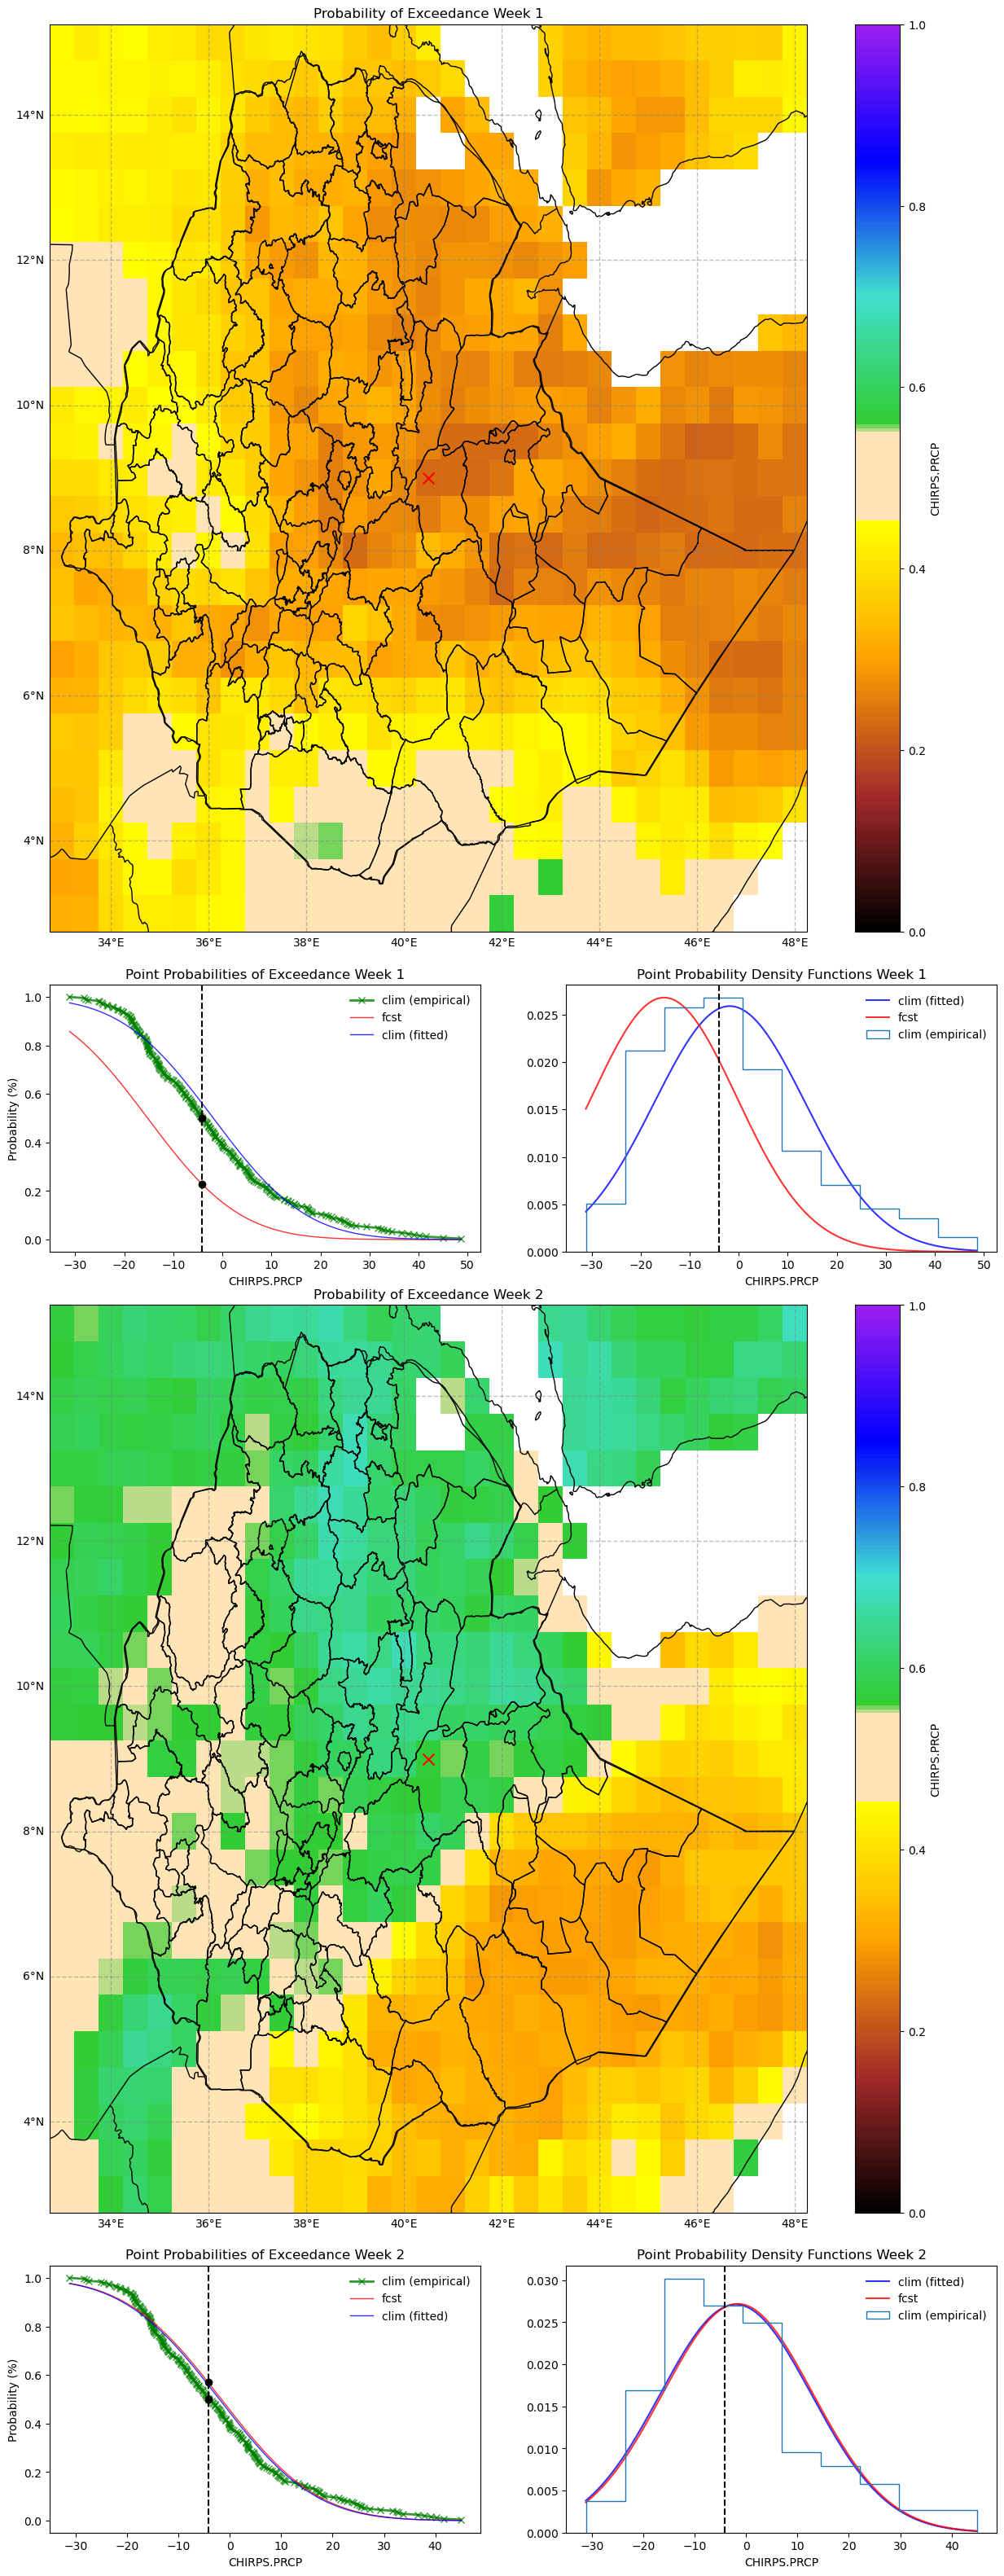

In [19]:
subseasonal.plot_flex_forecasts(predictand_name, exceedance_prob, point_latitude, point_longitude, download_args["predictand_extent"], transformed_threshold, fcst_scale, climo_scale, fcst_mu, climo_mu, Y2, cpt_args['transform_predictand'], ntrain, Y, MOS, domain_dir, color_bar, regionShape)